In [89]:
import pandas as pd
import numpy as np
import xgboost as xgb, lightgbm as lgbm, catboost as catb
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [90]:
import warnings
warnings.simplefilter('ignore')

In [91]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [185]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 18):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [92]:
df = pd.read_csv('Data/prepared_train_data_without_new_features.csv')

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 27 columns):
Annual Income                   7500 non-null float64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Bankruptcies                    7500 non-null float64
Term                            7500 non-null int64
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null float64
Credit Default                  7500 non-null int64
Home Ownership_Home Mortgage    7500 non-null int64
Home Ownership_Own Home         7500 non-null int64
Home Ownership_Rent             7500 no

In [94]:
target = 'Credit Default'

In [95]:
y = df[target]
X = df.drop(target, axis=1)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [97]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)

In [98]:
y_train = df_balanced[target]
X_train = df_balanced.drop(target, axis=1)

In [99]:
xgb_model = xgb.XGBClassifier(learning_rate=0.2, random_state=42)

In [100]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [101]:
y_train_pred = xgb_model.predict(X_train)

In [102]:
y_test_pred = xgb_model.predict(X_test)

In [103]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [104]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4074
           1       0.92      0.93      0.92      3102

    accuracy                           0.93      7176
   macro avg       0.93      0.93      0.93      7176
weighted avg       0.93      0.93      0.93      7176

TEST

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1313
           1       0.44      0.42      0.43       562

    accuracy                           0.66      1875
   macro avg       0.60      0.59      0.59      1875
weighted avg       0.66      0.66      0.66      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1010  303
1                327  235


In [105]:
params = {'n_estimators': [100, 300, 500, 700, 1000], 'max_depth': [3, 6, 9, 12], 'learning_rate': [0.2, 0.5, 1]}

In [106]:
xgb_model_s = xgb.XGBClassifier(random_state=42)

In [107]:
gs = GridSearchCV(xgb_model_s, params, scoring='f1', cv=3, n_jobs=-1)

In [108]:
%%time
gs.fit(X_train, y_train)

Wall time: 1min 48s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     objective='binary:logistic',
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     

In [109]:
gs.best_params_

{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 1000}

In [110]:
gs.best_score_

0.7658274989804137

In [111]:
lgbm_model = lgbm.LGBMClassifier(random_state=42)

In [112]:
gs_3 = GridSearchCV(lgbm_model, params, scoring='f1', cv=3, n_jobs=-1)

In [113]:
%%time
gs_3.fit(X_train, y_train)

Wall time: 14.3 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.5, 1],
                         'max_d

In [114]:
gs_3.best_score_

0.7688973990354508

In [126]:
gs_3.best_params_

{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 500}

In [115]:
catb_model = catb.CatBoostClassifier(random_state=42)

In [116]:
params_cat = {'learning_rate': [0.2, 0.5, 1], 'depth': [None, 3, 6, 9, 12], 'iterations': [300, 500, 1000, 1500]}

In [117]:
gs_4 = GridSearchCV(catb_model, params_cat, scoring='f1', cv=3, n_jobs=-1)

In [118]:
%%time
gs_4.fit(X_train, y_train)

0:	learn: 0.6336065	total: 119ms	remaining: 59.6s
1:	learn: 0.5994969	total: 183ms	remaining: 45.6s
2:	learn: 0.5776392	total: 246ms	remaining: 40.8s
3:	learn: 0.5570529	total: 310ms	remaining: 38.4s
4:	learn: 0.5390349	total: 375ms	remaining: 37.1s
5:	learn: 0.5244480	total: 439ms	remaining: 36.1s
6:	learn: 0.5092700	total: 503ms	remaining: 35.4s
7:	learn: 0.4956133	total: 567ms	remaining: 34.9s
8:	learn: 0.4719642	total: 631ms	remaining: 34.4s
9:	learn: 0.4580506	total: 694ms	remaining: 34s
10:	learn: 0.4481736	total: 759ms	remaining: 33.7s
11:	learn: 0.4338417	total: 823ms	remaining: 33.5s
12:	learn: 0.4198326	total: 889ms	remaining: 33.3s
13:	learn: 0.4078251	total: 953ms	remaining: 33.1s
14:	learn: 0.3922432	total: 1.02s	remaining: 32.9s
15:	learn: 0.3836175	total: 1.08s	remaining: 32.7s
16:	learn: 0.3727677	total: 1.15s	remaining: 32.6s
17:	learn: 0.3593321	total: 1.21s	remaining: 32.4s
18:	learn: 0.3419775	total: 1.27s	remaining: 32.3s
19:	learn: 0.3308654	total: 1.34s	remaining

161:	learn: 0.0329747	total: 10.8s	remaining: 22.6s
162:	learn: 0.0324810	total: 10.9s	remaining: 22.5s
163:	learn: 0.0322407	total: 10.9s	remaining: 22.4s
164:	learn: 0.0319724	total: 11s	remaining: 22.4s
165:	learn: 0.0314816	total: 11.1s	remaining: 22.3s
166:	learn: 0.0311759	total: 11.1s	remaining: 22.2s
167:	learn: 0.0309814	total: 11.2s	remaining: 22.1s
168:	learn: 0.0306526	total: 11.3s	remaining: 22.1s
169:	learn: 0.0304217	total: 11.3s	remaining: 22s
170:	learn: 0.0300343	total: 11.4s	remaining: 21.9s
171:	learn: 0.0298888	total: 11.5s	remaining: 21.9s
172:	learn: 0.0296734	total: 11.5s	remaining: 21.8s
173:	learn: 0.0295188	total: 11.6s	remaining: 21.7s
174:	learn: 0.0293191	total: 11.7s	remaining: 21.6s
175:	learn: 0.0289427	total: 11.7s	remaining: 21.6s
176:	learn: 0.0286669	total: 11.8s	remaining: 21.5s
177:	learn: 0.0283895	total: 11.8s	remaining: 21.4s
178:	learn: 0.0280942	total: 11.9s	remaining: 21.4s
179:	learn: 0.0279241	total: 12s	remaining: 21.3s
180:	learn: 0.0277

323:	learn: 0.0114783	total: 21.6s	remaining: 11.7s
324:	learn: 0.0114006	total: 21.6s	remaining: 11.7s
325:	learn: 0.0113673	total: 21.7s	remaining: 11.6s
326:	learn: 0.0113329	total: 21.8s	remaining: 11.5s
327:	learn: 0.0112839	total: 21.8s	remaining: 11.5s
328:	learn: 0.0112233	total: 21.9s	remaining: 11.4s
329:	learn: 0.0111960	total: 22s	remaining: 11.3s
330:	learn: 0.0111560	total: 22s	remaining: 11.3s
331:	learn: 0.0111186	total: 22.1s	remaining: 11.2s
332:	learn: 0.0110613	total: 22.2s	remaining: 11.1s
333:	learn: 0.0110238	total: 22.2s	remaining: 11.1s
334:	learn: 0.0109671	total: 22.3s	remaining: 11s
335:	learn: 0.0109064	total: 22.4s	remaining: 10.9s
336:	learn: 0.0108720	total: 22.5s	remaining: 10.9s
337:	learn: 0.0108426	total: 22.5s	remaining: 10.8s
338:	learn: 0.0108093	total: 22.6s	remaining: 10.7s
339:	learn: 0.0107740	total: 22.7s	remaining: 10.7s
340:	learn: 0.0107106	total: 22.8s	remaining: 10.6s
341:	learn: 0.0106593	total: 22.8s	remaining: 10.6s
342:	learn: 0.0106

484:	learn: 0.0065641	total: 32.3s	remaining: 999ms
485:	learn: 0.0065393	total: 32.4s	remaining: 933ms
486:	learn: 0.0065393	total: 32.4s	remaining: 866ms
487:	learn: 0.0065217	total: 32.5s	remaining: 799ms
488:	learn: 0.0065013	total: 32.6s	remaining: 733ms
489:	learn: 0.0065010	total: 32.6s	remaining: 666ms
490:	learn: 0.0065009	total: 32.7s	remaining: 599ms
491:	learn: 0.0064824	total: 32.8s	remaining: 533ms
492:	learn: 0.0064564	total: 32.8s	remaining: 466ms
493:	learn: 0.0064369	total: 32.9s	remaining: 400ms
494:	learn: 0.0064141	total: 33s	remaining: 333ms
495:	learn: 0.0063963	total: 33s	remaining: 266ms
496:	learn: 0.0063940	total: 33.1s	remaining: 200ms
497:	learn: 0.0063733	total: 33.2s	remaining: 133ms
498:	learn: 0.0063618	total: 33.2s	remaining: 66.6ms
499:	learn: 0.0063440	total: 33.3s	remaining: 0us
Wall time: 33min 35s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x00000231DF1BB518>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [None, 3, 6, 9, 12],
                         'iterations': [300, 500, 1000, 1500],
                         'learning_rate': [0.2, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [119]:
gs_4.best_score_

0.7713746348849992

In [120]:
gs_4.best_params_

{'depth': 12, 'iterations': 500, 'learning_rate': 0.2}

In [121]:
model = catb.CatBoostClassifier(depth=12, iterations=500, learning_rate=0.2, random_state=42)

In [122]:
model.fit(X_train, y_train)

0:	learn: 0.6336065	total: 65.8ms	remaining: 32.8s
1:	learn: 0.5994969	total: 130ms	remaining: 32.4s
2:	learn: 0.5776392	total: 196ms	remaining: 32.4s
3:	learn: 0.5570529	total: 260ms	remaining: 32.2s
4:	learn: 0.5390349	total: 324ms	remaining: 32.1s
5:	learn: 0.5244480	total: 389ms	remaining: 32.1s
6:	learn: 0.5092700	total: 455ms	remaining: 32.1s
7:	learn: 0.4956133	total: 525ms	remaining: 32.3s
8:	learn: 0.4719642	total: 589ms	remaining: 32.2s
9:	learn: 0.4580506	total: 656ms	remaining: 32.1s
10:	learn: 0.4481736	total: 720ms	remaining: 32s
11:	learn: 0.4338417	total: 786ms	remaining: 32s
12:	learn: 0.4198326	total: 852ms	remaining: 31.9s
13:	learn: 0.4078251	total: 918ms	remaining: 31.9s
14:	learn: 0.3922432	total: 982ms	remaining: 31.8s
15:	learn: 0.3836175	total: 1.05s	remaining: 31.7s
16:	learn: 0.3727677	total: 1.11s	remaining: 31.6s
17:	learn: 0.3593321	total: 1.18s	remaining: 31.5s
18:	learn: 0.3419775	total: 1.24s	remaining: 31.5s
19:	learn: 0.3308654	total: 1.31s	remaining:

162:	learn: 0.0324810	total: 10.9s	remaining: 22.6s
163:	learn: 0.0322407	total: 11s	remaining: 22.5s
164:	learn: 0.0319724	total: 11s	remaining: 22.4s
165:	learn: 0.0314816	total: 11.1s	remaining: 22.4s
166:	learn: 0.0311759	total: 11.2s	remaining: 22.3s
167:	learn: 0.0309814	total: 11.3s	remaining: 22.2s
168:	learn: 0.0306526	total: 11.3s	remaining: 22.2s
169:	learn: 0.0304217	total: 11.4s	remaining: 22.1s
170:	learn: 0.0300343	total: 11.5s	remaining: 22.1s
171:	learn: 0.0298888	total: 11.6s	remaining: 22.1s
172:	learn: 0.0296734	total: 11.6s	remaining: 22s
173:	learn: 0.0295188	total: 11.7s	remaining: 21.9s
174:	learn: 0.0293191	total: 11.8s	remaining: 21.9s
175:	learn: 0.0289427	total: 11.9s	remaining: 21.8s
176:	learn: 0.0286669	total: 11.9s	remaining: 21.8s
177:	learn: 0.0283895	total: 12s	remaining: 21.7s
178:	learn: 0.0280942	total: 12.1s	remaining: 21.6s
179:	learn: 0.0279241	total: 12.1s	remaining: 21.6s
180:	learn: 0.0277663	total: 12.2s	remaining: 21.5s
181:	learn: 0.027591

321:	learn: 0.0116111	total: 21.8s	remaining: 12.1s
322:	learn: 0.0115335	total: 21.9s	remaining: 12s
323:	learn: 0.0114783	total: 22s	remaining: 11.9s
324:	learn: 0.0114006	total: 22s	remaining: 11.9s
325:	learn: 0.0113673	total: 22.1s	remaining: 11.8s
326:	learn: 0.0113329	total: 22.2s	remaining: 11.7s
327:	learn: 0.0112839	total: 22.3s	remaining: 11.7s
328:	learn: 0.0112233	total: 22.3s	remaining: 11.6s
329:	learn: 0.0111960	total: 22.4s	remaining: 11.5s
330:	learn: 0.0111560	total: 22.5s	remaining: 11.5s
331:	learn: 0.0111186	total: 22.6s	remaining: 11.4s
332:	learn: 0.0110613	total: 22.6s	remaining: 11.3s
333:	learn: 0.0110238	total: 22.7s	remaining: 11.3s
334:	learn: 0.0109671	total: 22.8s	remaining: 11.2s
335:	learn: 0.0109064	total: 22.8s	remaining: 11.1s
336:	learn: 0.0108720	total: 22.9s	remaining: 11.1s
337:	learn: 0.0108426	total: 23s	remaining: 11s
338:	learn: 0.0108093	total: 23s	remaining: 10.9s
339:	learn: 0.0107740	total: 23.1s	remaining: 10.9s
340:	learn: 0.0107106	to

480:	learn: 0.0066411	total: 32.8s	remaining: 1.29s
481:	learn: 0.0066228	total: 32.9s	remaining: 1.23s
482:	learn: 0.0066042	total: 32.9s	remaining: 1.16s
483:	learn: 0.0065858	total: 33s	remaining: 1.09s
484:	learn: 0.0065641	total: 33.1s	remaining: 1.02s
485:	learn: 0.0065393	total: 33.1s	remaining: 955ms
486:	learn: 0.0065393	total: 33.2s	remaining: 886ms
487:	learn: 0.0065217	total: 33.3s	remaining: 818ms
488:	learn: 0.0065013	total: 33.3s	remaining: 750ms
489:	learn: 0.0065010	total: 33.4s	remaining: 682ms
490:	learn: 0.0065009	total: 33.5s	remaining: 614ms
491:	learn: 0.0064824	total: 33.5s	remaining: 545ms
492:	learn: 0.0064564	total: 33.6s	remaining: 477ms
493:	learn: 0.0064369	total: 33.7s	remaining: 409ms
494:	learn: 0.0064141	total: 33.7s	remaining: 341ms
495:	learn: 0.0063963	total: 33.8s	remaining: 273ms
496:	learn: 0.0063940	total: 33.9s	remaining: 204ms
497:	learn: 0.0063733	total: 33.9s	remaining: 136ms
498:	learn: 0.0063618	total: 34s	remaining: 68.1ms
499:	learn: 0.0

In [169]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [170]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1313
           1       0.46      0.30      0.36       562

    accuracy                           0.69      1875
   macro avg       0.60      0.57      0.58      1875
weighted avg       0.66      0.69      0.66      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1119  194
1                395  167


In [171]:
y_test_proba = model.predict_proba(X_test)

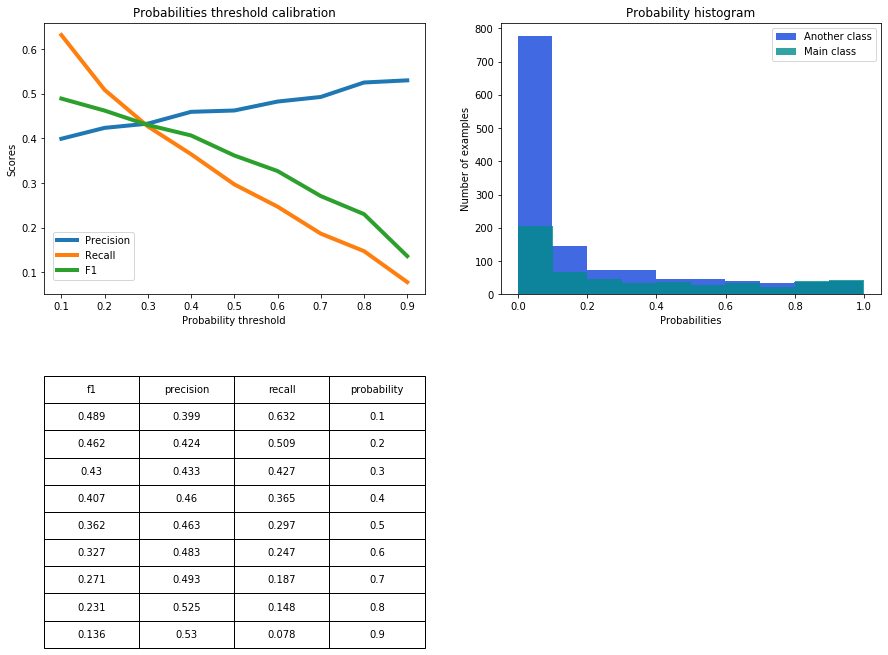

In [172]:
show_proba_calibration_plots(y_test_proba[:, 1], y_test)

In [127]:
model_2 = lgbm.LGBMClassifier(learning_rate=0.2, n_estimators=500, max_depth=6, random_state=42)

In [128]:
model_2.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [165]:
y_train_pred = model_2.predict(X_train)
y_test_pred = model_2.predict(X_test)

In [166]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1313
           1       0.45      0.34      0.39       562

    accuracy                           0.68      1875
   macro avg       0.60      0.58      0.58      1875
weighted avg       0.66      0.68      0.66      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1074  239
1                369  193


In [167]:
y_test_proba = model_2.predict_proba(X_test)

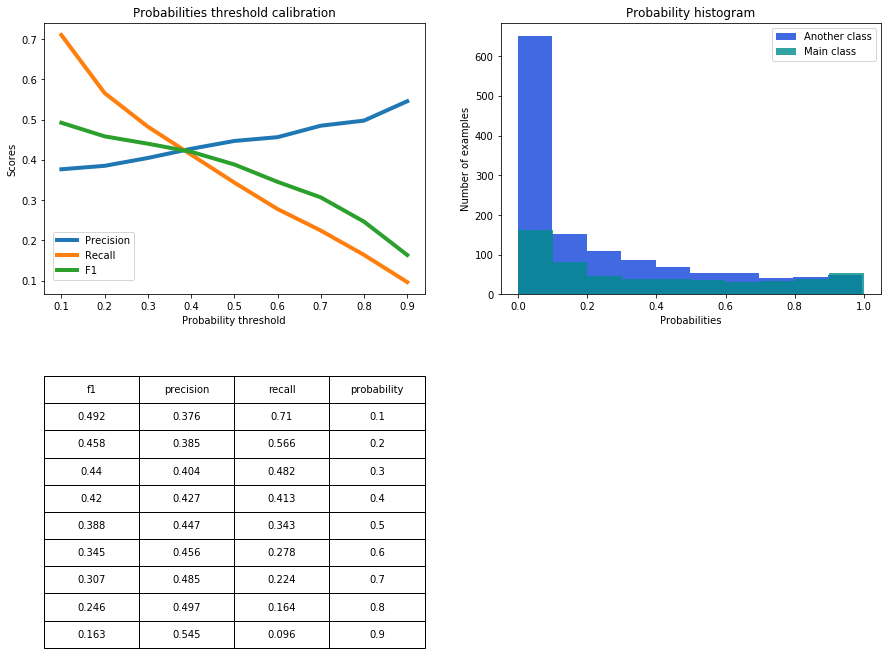

In [168]:
show_proba_calibration_plots(y_test_proba[:, 1], y_test)

In [131]:
model_3 = xgb.XGBClassifier(learning_rate=0.2, max_depth=9, n_estimators=1000, random_state=42)

In [132]:
model_3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [161]:
y_train_pred = model_3.predict(X_train)
y_test_pred = model_3.predict(X_test)

In [162]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1313
           1       0.47      0.31      0.37       562

    accuracy                           0.69      1875
   macro avg       0.60      0.58      0.58      1875
weighted avg       0.66      0.69      0.67      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1113  200
1                388  174


In [163]:
y_test_proba = model_3.predict_proba(X_test)

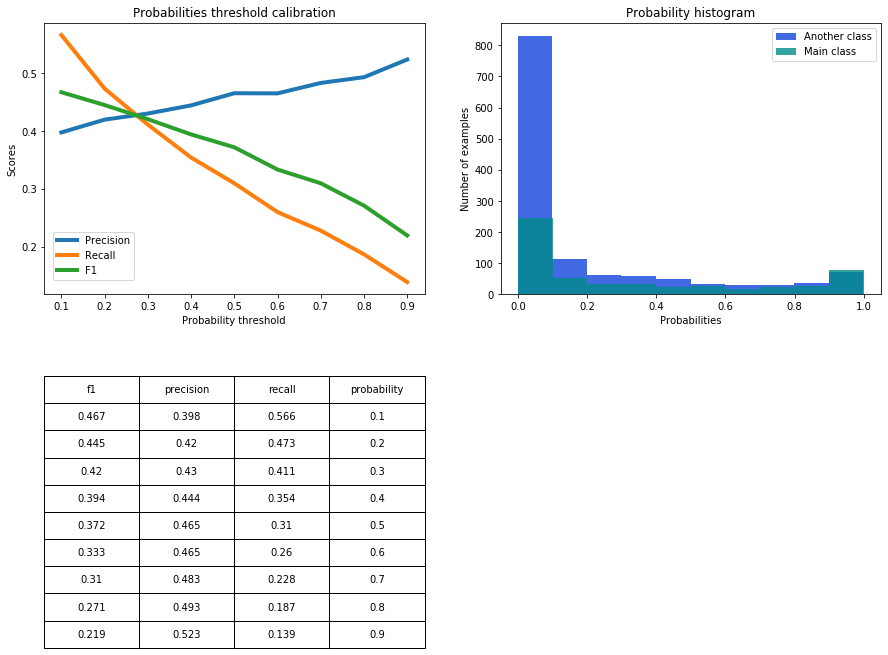

In [164]:
show_proba_calibration_plots(y_test_proba[:, 1], y_test)

In [135]:
params = {'n_estimators': [100, 300, 500, 700, 1000], 'max_depth': [3, 6, 9, 12],
          'learning_rate': [0.2, 0.5, 1], 'reg_lambda': [0.1, 1, 10, 50]}

In [136]:
gs_5 = GridSearchCV(lgbm_model, params, scoring='f1', cv=3, n_jobs=-1)

In [137]:
gs_5.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.5, 1],
                         'max_d

In [138]:
gs_5.best_score_

0.7648853983523894

In [139]:
gs_5.best_params_

{'learning_rate': 0.5, 'max_depth': 12, 'n_estimators': 1000, 'reg_lambda': 1}

In [148]:
model_4 = lgbm.LGBMClassifier(learning_rate=0.5, n_estimators=1000, max_depth=12, reg_lambda=1, random_state=42)

In [149]:
model_4.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=12,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [150]:
y_train_pred = model_4.predict(X_train)
y_test_pred = model_4.predict(X_test)

In [151]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1313
           1       0.42      0.32      0.36       562

    accuracy                           0.66      1875
   macro avg       0.58      0.57      0.57      1875
weighted avg       0.64      0.66      0.65      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1063  250
1                381  181


In [153]:
y_test_proba = model_4.predict_proba(X_test)

In [155]:
y_test_proba

array([[9.99586709e-01, 4.13290631e-04],
       [9.44124503e-01, 5.58754968e-02],
       [9.77245109e-01, 2.27548912e-02],
       ...,
       [3.45771528e-01, 6.54228472e-01],
       [8.64773243e-01, 1.35226757e-01],
       [9.91414218e-01, 8.58578226e-03]])

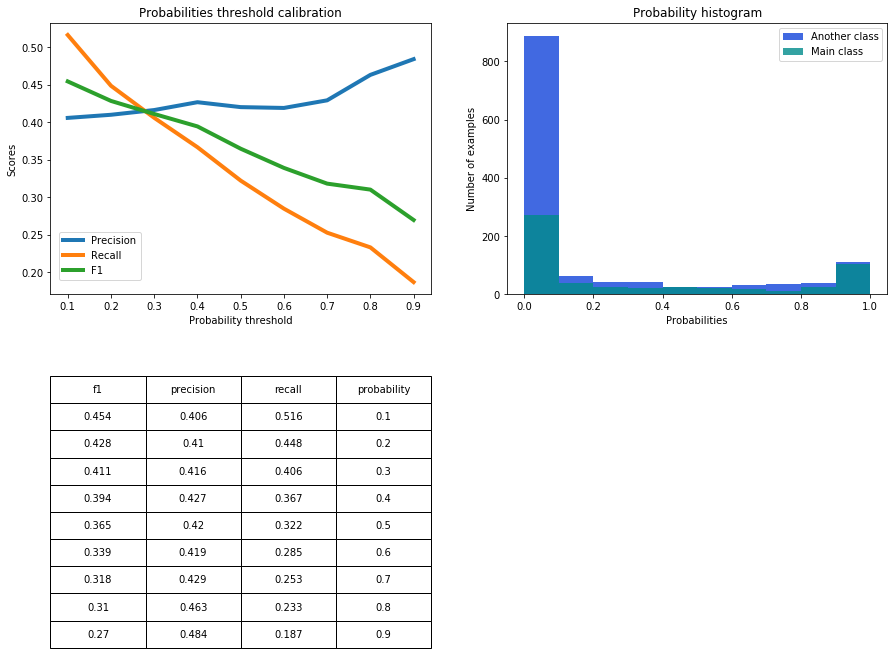

In [159]:
show_proba_calibration_plots(y_test_proba[:, 1], y_test)

In [173]:
params = {'n_estimators': [100, 300, 500, 700, 1000], 'max_depth': [3, 6, 9, 12],
          'learning_rate': [0.2, 0.5, 1], 'reg_lambda': [0.1, 1, 10, 50], 'num_leaves': [10, 20, 30, 40, 50]}

In [174]:
gs_6 = GridSearchCV(lgbm_model, params, scoring='f1', cv=3, n_jobs=-1)

In [176]:
%%time
gs_6.fit(X_train, y_train)

Wall time: 5min 11s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.5, 1],
                         'max_d

In [177]:
gs_6.best_params_

{'learning_rate': 0.2,
 'max_depth': 12,
 'n_estimators': 300,
 'num_leaves': 50,
 'reg_lambda': 1}

In [178]:
gs_6.best_score_

0.7687371690620529

In [179]:
model_5 = lgbm.LGBMClassifier(learning_rate=0.2, n_estimators=300, max_depth=12, reg_lambda=1, num_leaves=50, random_state=42)

In [180]:
model_5.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=12,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=50, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [181]:
y_train_pred = model_5.predict(X_train)
y_test_pred = model_5.predict(X_test)

In [182]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4074
           1       1.00      1.00      1.00      3102

    accuracy                           1.00      7176
   macro avg       1.00      1.00      1.00      7176
weighted avg       1.00      1.00      1.00      7176

TEST

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1313
           1       0.44      0.32      0.37       562

    accuracy                           0.68      1875
   macro avg       0.59      0.58      0.58      1875
weighted avg       0.65      0.68      0.66      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1085  228
1                380  182


In [183]:
y_test_proba = model_5.predict_proba(X_test)

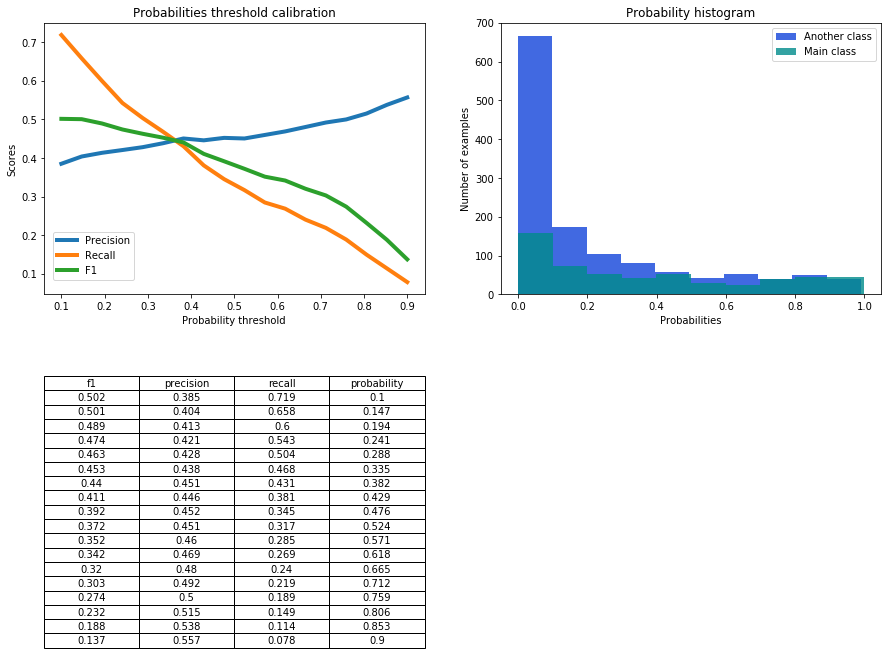

In [186]:
show_proba_calibration_plots(y_test_proba[:, 1], y_test)